In [ ]:
# !pip install bokeh
# !pip install plotly

In [6]:
import numpy as np
import os
import pandas as pd
import time as time
import matplotlib.pyplot as plt
import glob
from scipy import stats
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
import plotly.graph_objects as go
import pickle
%matplotlib inline
output_notebook()

Loading BokehJS ...

In [7]:
import sys
sys.path.append('../../')

In [8]:
from src.actmat_matrixprocessing import *

### Sometimes it is "Pre_sleep", sometimes it is "Pre-sleep", check data to make sure the name is correct

In [13]:
ordered_list = ['Pre-sleep', 'Trial1','Post_Trial1', 'Trial2', 'Post_Trial2', 'Trial3', 
                'Post_Trial3', 'Trial4', 'Post_Trial4', 'Trial5', 'Post_Trial5']
complete_list = ['Pre-sleep', 'Trial1','Post_Trial1', 'Trial2', 'Post_Trial2', 'Trial3', 
                'Post_Trial3', 'Trial4', 'Post_Trial4', 'Trial5', 'PT5_part1', 'PT5_part2', 'PT5_part3', 'PT5_part4']
trial_list = ['Trial1', 'Trial2', 'Trial3', 'Trial4', 'Trial5']

Total_time = 430

### Change `foler_name` into the correct folder

In [14]:
folder_name = "Rat7_SD1_HC"
path = "D:\Internship_Radbound\Cell_Assembly\Process_data\\" + folder_name
neuron_name_dict, actmat_dict = load_actmat(path)

In [15]:
print(neuron_name_dict)

{0: 'RGS_PROJECT_RGS14_PFC_Rn7_HC_SD1_T11_UID5', 1: 'RGS_PROJECT_RGS14_PFC_Rn7_HC_SD1_T11_UID7'}


In [16]:
actmat_all_trials = combine_all_trial(actmat_dict, trial_list)
actmat_all_time = combine_all_trial(actmat_dict, ordered_list)

### Uncomment code below if you haven't run cell assmebly yet

In [19]:
# patterns, significance, zactmat = assembly.runPatterns(actmat_all_trials, method='ica', nullhyp = 'mp', nshu = 1000, percentile = 99, tracywidom = False)
# np.save("patterns", patterns)
# np.save("zactmat", zactmat)

### Get saved configuration of patterns and zactmat used for assembly

In [20]:
patterns = np.load('patterns.npy')
zactmat = np.load('zactmat.npy')
patterns = process_pattern(patterns)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


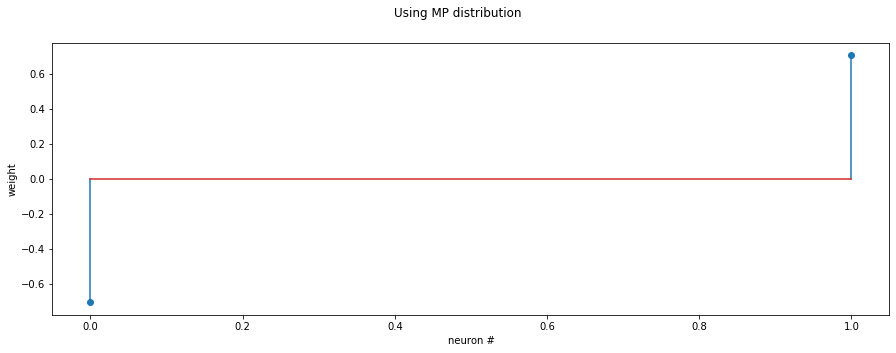

In [21]:
plt.figure(figsize=(15,5))
for (pi, pattern) in enumerate(patterns):
        plt.subplot(1,len(patterns),1+pi)
        plt.stem(pattern)
        plt.xlabel('neuron #')
        plt.ylabel('weight')
plt.suptitle('Using MP distribution')
plt.savefig('cell_assembly_group.png')

In [22]:
important_neuron_dict = get_save_important_neuron(neuron_name_dict, patterns)
important_neuron_dict

{0: []}

### Get all precessed data:

- zactmat_dict: dict of actmat that has been zscore
- assemblyAct_each_trial_dict: dict with trial period name as key and assemblyAct for each assembly group for each period of time as value
- assemblyAct_mean_dict: dict with trial period name as key and mean of assemblyAct as value (PT5 splitted)

In [23]:
zactmat_dict = {}
assemblyAct_each_trial_dict = {}
assemblyAct_mean_dict = {}
actmat_dict_split_PT5 = get_actmat_dict_with_split_trial5(actmat_dict)
for duration_name, each_duration_actmat in actmat_dict_split_PT5.items():
    z_score_actmat = get_zscore(each_duration_actmat)
    zactmat_dict[duration_name] = z_score_actmat
    assembly_act = assembly.computeAssemblyActivity(patterns, each_duration_actmat)
    assembly_act = clean_assemblyAct(assembly_act)
    assemblyAct_each_trial_dict[duration_name] = assembly_act
    mean_each_assembly = assembly_act.mean(axis = 1)
#     time_bins_each_trial = int(len(assembly_act[0]) / (60*(1/0.025)))
    assemblyAct_mean_dict[duration_name] = [[x] for x in mean_each_assembly]

In [24]:
time_all_mean = combine_all_trial(assemblyAct_mean_dict, complete_list)
lst_time_all_mean = list(time_all_mean) 
# creating df object with columns specified    
mean_df = pd.DataFrame(lst_time_all_mean, columns = complete_list).dropna()
mean_df.to_csv("mean_df.csv")
mean_of_time_period_unfiltered = mean_df.mean()
sem_of_time_period_unfiltered = mean_df.sem()

Rat7_SD1_HC_assemlyAct_strength_mean_unfiltered.png


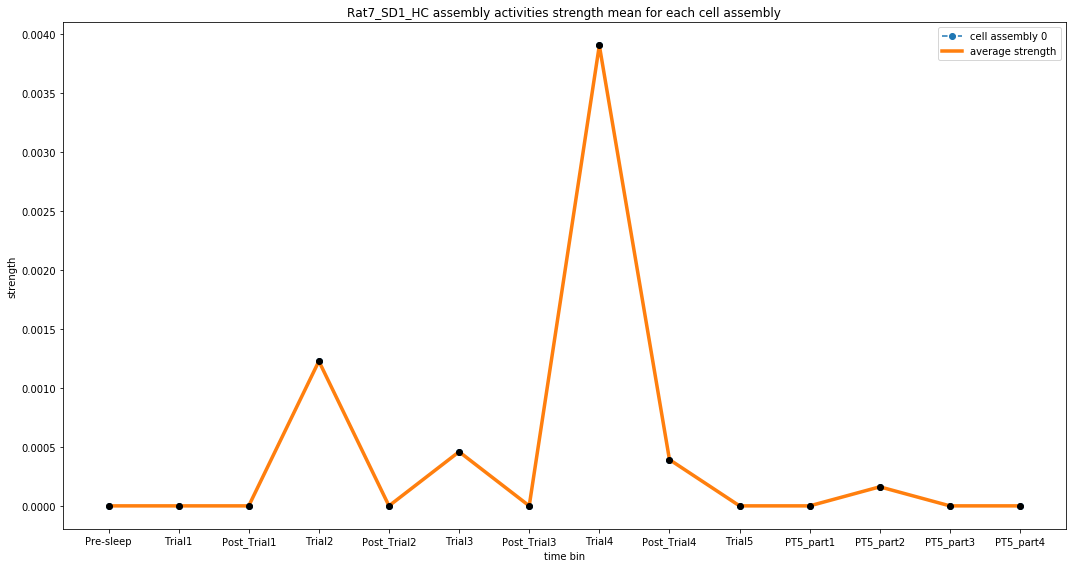

In [25]:
plt.figure(figsize=(15,8))
labels = complete_list
x = [x for x in range(len(labels))]
ticks = [x for x in range(len(labels))]
for index in mean_df.index:
#     print(index)
    label_str = 'cell assembly '+ str(index)
#     print(list(mean_filter_df.loc[index]))
    plt.plot(list(mean_df.loc[index]), label = label_str, linestyle='--', marker='o')
plt.title(folder_name + ' assembly activities strength mean for each cell assembly')
plt.xlabel('time bin')
plt.ylabel('strength')
plt.xticks(ticks, labels)

plt.plot(mean_of_time_period_unfiltered, linewidth=3.5, label = "average strength")
plt.errorbar(x, mean_of_time_period_unfiltered, sem_of_time_period_unfiltered,  fmt='ok', color='black',
             ecolor='gray', elinewidth=3, capsize=0)
# plt.axhline(y = 0.5, color = 'r', linestyle = '-')
# plt.axhspan( 0.5, 1, color='silver', alpha=0.5, label = "outlier")

plt.tight_layout()
fig_name = folder_name +'_assemlyAct_strength_mean_unfiltered.png'
print(fig_name)
plt.legend()
plt.savefig(fig_name)

### Get average strength for all trials and post-trials:

save as png at data folder

In [26]:
time_all_mean = combine_all_trial(assemblyAct_mean_dict, complete_list)
#Filter out the outliers of each trial
time_all_mean_filered = np.where(time_all_mean < 0.5, time_all_mean, np.nan)
lst = list(time_all_mean_filered) 
# creating df object with columns specified    
mean_filter_df = pd.DataFrame(lst, columns = complete_list).dropna()
mean_filter_df.to_csv("mean_filter_df.csv")
mean_of_each_time_period = mean_filter_df.mean()
sem_of_each_time_period = mean_filter_df.sem()
dict(mean_of_each_time_period).values()

dict_values([0.0, 0.0, 0.0, 0.0012260860872434427, 0.0, 0.000458641267509357, 0.0, 0.0039013302506408737, 0.00039205681381213053, 0.0, 0.0, 0.00016137806231716567, 0.0, 0.0])

Rat7_SD1_HC_assemlyAct_strength_mean.png


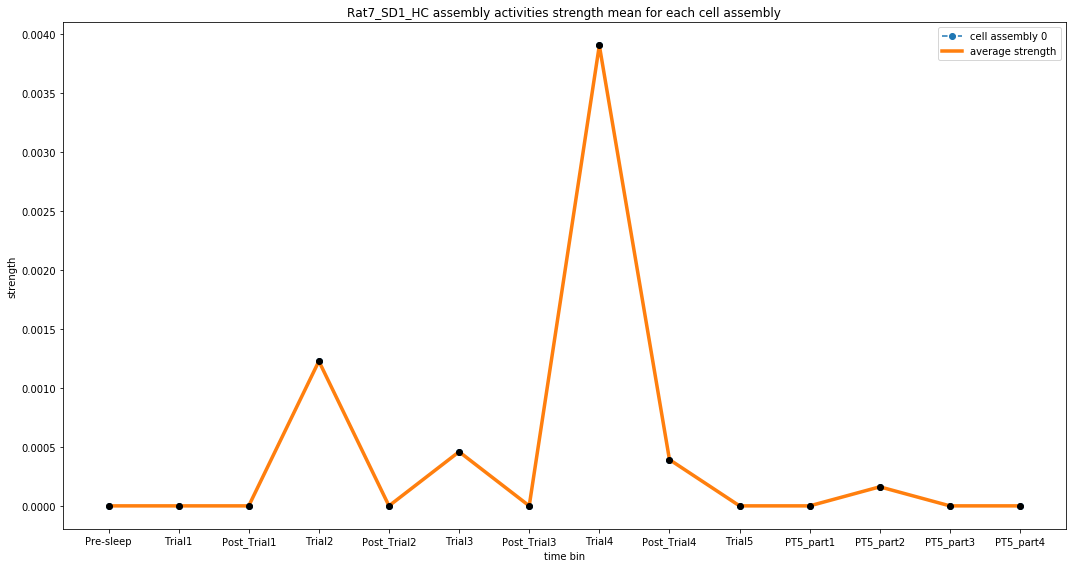

In [27]:
plt.figure(figsize=(15,8))
labels = complete_list
x = [x for x in range(len(labels))]
ticks = [x for x in range(len(labels))]
for index in mean_filter_df.index:
#     print(index)
    label_str = 'cell assembly '+ str(index)
#     print(list(mean_filter_df.loc[index]))
    plt.plot(list(mean_filter_df.loc[index]), label = label_str, linestyle='--', marker='o')
plt.title(folder_name + ' assembly activities strength mean for each cell assembly')
plt.xlabel('time bin')
plt.ylabel('strength')
plt.xticks(ticks, labels)

plt.plot(mean_of_each_time_period, linewidth=3.5, label = "average strength")
plt.errorbar(x, mean_of_each_time_period, sem_of_each_time_period,  fmt='ok', color='black',
             ecolor='gray', elinewidth=3, capsize=0)
# plt.axhline(y = 0.5, color = 'r', linestyle = '-')
# plt.axhspan( 0.5, 1, color='silver', alpha=0.5, label = "outlier")

plt.tight_layout()
fig_name = folder_name +'_assemlyAct_strength_mean.png'
print(fig_name)
plt.legend()
plt.savefig(fig_name)